In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc,roc_auc_score
from sklearn.linear_model import LinearRegression

In [15]:
x = np.random.normal(0,1,100000)
x2 = np.random.normal(0,1,100000)
#x = np.random.multivariate_normal(mean, cov, (3, 3))

(array([7.9000e+01, 1.2730e+03, 8.7230e+03, 2.5872e+04, 3.5266e+04,
        2.1858e+04, 6.1130e+03, 7.8100e+02, 3.2000e+01, 3.0000e+00]),
 array([-4.02796727, -3.11015216, -2.19233706, -1.27452195, -0.35670685,
         0.56110825,  1.47892336,  2.39673846,  3.31455356,  4.23236867,
         5.15018377]),
 <a list of 10 Patch objects>)

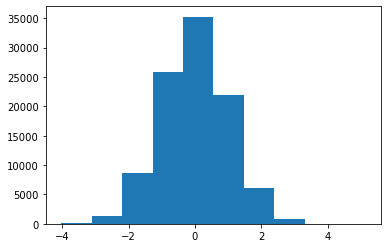

In [16]:
plt.hist(x)

In [17]:
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, ReLU, ELU, PReLU, Input, Concatenate, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import mse, binary_crossentropy
import tensorflow as tf

In [18]:
'''
def myloss(y_true, y_pred, alpha = 0.):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput
'''

'\ndef myloss(y_true, y_pred, alpha = 0.):\n    #alpha determines the amount of decorrelation; 0 means no decorrelation.\n    \n    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.\n    #g(x) = y_pred[:,0]\n    #f(g(x)) = y_pred[:,1]\n    #h(x) = y_pred[:,2]\n    #h(g(x)) = y_pred[:,3]\n    \n    myoutput =  mse(y_true[:,0],y_pred[:,1])                 - 0.1*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2]))                 - 0.1*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))\n    return myoutput\n'

In [19]:
'''
#setup the model

myinput = Input(shape=(1,))
encoded = Dense(5, activation='elu')(myinput)
encoded = Dense(5, activation='elu')(encoded)
encoded = Dense(1, activation='linear')(encoded)

encoder = Model(myinput, encoded)
encoder2 = encoder(encoder(myinput))
autoencoder = Model(myinput, encoder2)

combinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))

myinput_classify = Input(shape=(1,))
myclassifier = Dense(128, activation='elu')(myinput_classify)
myclassifier = Dense(64, activation='elu')(myclassifier)
myclassifier = Dense(1, activation='sigmoid')(myclassifier)
myclassifier_model = Model(myinput_classify, myclassifier)
myclassifier_input = myclassifier_model(myinput)
myclassifier_encoded = myclassifier_model(encoded)

combinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))

#First, pretrain the autoencoder:
#autoencoder.compile(optimizer='adam', loss='mse')
#autoencoder.fit(x,x, epochs=5, batch_size=int(0.01*len(x)))

preds = []
preds += [encoder.predict(np.linspace(-4,4,10))]

for i in range(10):
    print("on i=",i)
    #Now, train the classifier
    encoded_x = encoder.predict(x)[:,0]
    myclassifier_model.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model.fit(np.concatenate([x,encoded_x]),np.concatenate([np.ones(len(x)),np.zeros(len(x))]), epochs=1, batch_size=int(0.01*len(x)))

    #y_scores = encoder.predict(np.concatenate([x,encoded_x]))
    #print(i,roc_auc_score(np.concatenate([np.ones(len(x)),np.zeros(len(x))]),y_scores))
    
    #Now, update the autoencoder
    for layer in myclassifier_model.layers[:]:
        layer.trainable = False

    combinedModel_classifier.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss(y_true, y_pred))
    combinedModel_classifier.fit(x,np.stack((x, x), axis=-1), epochs=1, batch_size=int(0.01*len(x)))
    
    preds += [encoder.predict(np.linspace(-4,4,10))]
    
    for layer in myclassifier_model.layers[:]:
        layer.trainable = True
'''

'\n#setup the model\n\nmyinput = Input(shape=(1,))\nencoded = Dense(5, activation=\'elu\')(myinput)\nencoded = Dense(5, activation=\'elu\')(encoded)\nencoded = Dense(1, activation=\'linear\')(encoded)\n\nencoder = Model(myinput, encoded)\nencoder2 = encoder(encoder(myinput))\nautoencoder = Model(myinput, encoder2)\n\ncombinedModel = Model(myinput,Concatenate(axis=-1)([encoded, encoder2]))\n\nmyinput_classify = Input(shape=(1,))\nmyclassifier = Dense(128, activation=\'elu\')(myinput_classify)\nmyclassifier = Dense(64, activation=\'elu\')(myclassifier)\nmyclassifier = Dense(1, activation=\'sigmoid\')(myclassifier)\nmyclassifier_model = Model(myinput_classify, myclassifier)\nmyclassifier_input = myclassifier_model(myinput)\nmyclassifier_encoded = myclassifier_model(encoded)\n\ncombinedModel_classifier = Model(myinput,Concatenate(axis=-1)([encoded, encoder2, myclassifier_input, myclassifier_encoded]))\n\n#First, pretrain the autoencoder:\n#autoencoder.compile(optimizer=\'adam\', loss=\'mse

In [20]:
'''
for i in range(len(preds)):
    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))
    pass
plt.legend(frameon=False)
'''

'\nfor i in range(len(preds)):\n    plt.plot(np.linspace(-4,4,10),preds[i],label=str(i))\n    pass\nplt.legend(frameon=False)\n'

In [21]:
#mypreds = combinedModel_classifier.predict(x)

In [22]:
'''
plt.scatter(x,mypreds[:,0],label="Encoder")
plt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("function value")
plt.legend(frameon=False)
'''

'\nplt.scatter(x,mypreds[:,0],label="Encoder")\nplt.scatter(x,mypreds[:,1],label=r"Autoencoder = Encoder$^2$")\nplt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=\':\',color="gray")\nplt.xlabel("x")\nplt.ylabel("function value")\nplt.legend(frameon=False)\n'

In [24]:
X = np.c_[x,x2]

In [25]:
def myloss2d(y_true, y_pred, alpha = 0.0):
    #alpha determines the amount of decorrelation; 0 means no decorrelation.
    
    #We want to learn f(g(x)) = x with g != identity and g(x) and x should have the same probability density.
    #g(x) = y_pred[:,0]
    #f(g(x)) = y_pred[:,1]
    #h(x) = y_pred[:,2]
    #h(g(x)) = y_pred[:,3]
    
    myoutput =  mse(y_true[:,0],y_pred[:,1]) \
                - alpha*binary_crossentropy(y_pred[:,2],K.ones_like(y_pred[:,2])) \
                - alpha*binary_crossentropy(y_pred[:,3],0.*K.ones_like(y_pred[:,2]))
    return myoutput

In [26]:
#setup the model

myinput_2d = Input(shape=(2,))
encoded_2d = Dense(5, activation='elu')(myinput_2d)
encoded_2d = Dense(5, activation='elu')(encoded_2d)
encoded_2d = Dense(2, activation='linear')(encoded_2d)

encoder_2d = Model(myinput_2d, encoded_2d)
encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
autoencoder_2d = Model(myinput_2d, encoder2_2d)

combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

myinput_classify_2d = Input(shape=(2,))
myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

preds = []
preds += [encoder_2d.predict(X)]

num_iters = 20

for i in range(num_iters):
    print("on i=",i)
    #Now, train the classifier
    encoded_x_2d = encoder_2d.predict(X)
    myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
    myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)), verbose=0)
        
    #Now, update the autoencoder
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = False

    combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
    combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)), verbose=0)
    
    autoencoder_2d.compile(optimizer='adam', loss='mse')
    autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)), verbose=0)
    
    preds += [encoder_2d.predict(X)]
    
    for layer in myclassifier_model_2d.layers[:]:
        layer.trainable = True

on i= 0
on i= 1
on i= 2
on i= 3
on i= 4
on i= 5
on i= 6
on i= 7
on i= 8
on i= 9
on i= 10
on i= 11
on i= 12
on i= 13
on i= 14
on i= 15
on i= 16
on i= 17
on i= 18
on i= 19


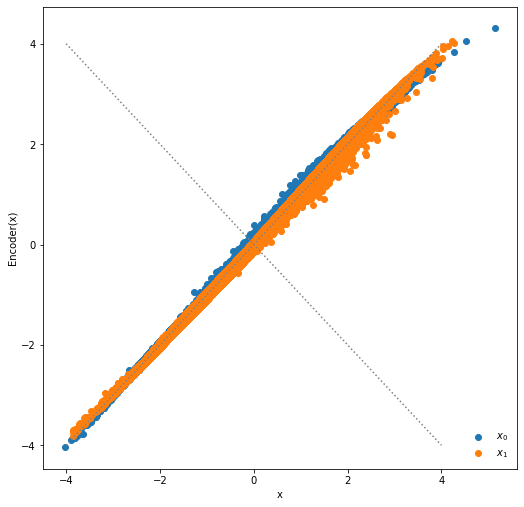

In [42]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],preds[-1][:,1],label="$x_0$")
plt.scatter(X[:,1],preds[-1][:,0],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Encoder(x)")
plt.legend(frameon=False)

In [28]:
mypreds = combinedModel_classifier_2d.predict(X)

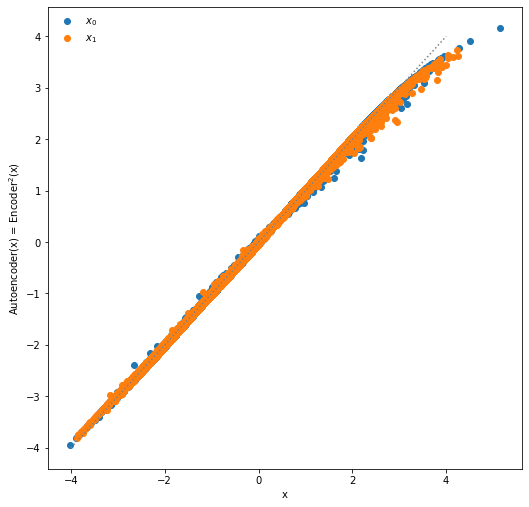

In [29]:
f = plt.figure(figsize=(8.5, 8.5))
plt.scatter(X[:,0],mypreds[:,2],label="$x_0$")
plt.scatter(X[:,1],mypreds[:,3],label="$x_1$")
plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
plt.xlabel("x")
plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
plt.legend(frameon=False)

In [30]:
'''for k in range(num_iters):
    
    print("on k=",k)

    K.clear_session()

    #setup the model

    myinput_2d = Input(shape=(2,))
    encoded_2d = Dense(5, activation='elu')(myinput_2d)
    encoded_2d = Dense(5, activation='elu')(encoded_2d)
    encoded_2d = Dense(2, activation='linear')(encoded_2d)

    encoder_2d = Model(myinput_2d, encoded_2d)
    encoder2_2d = encoder_2d(encoder_2d(myinput_2d))
    autoencoder_2d = Model(myinput_2d, encoder2_2d)

    combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))

    myinput_classify_2d = Input(shape=(2,))
    myclassifier_2d = Dense(128, activation='elu')(myinput_classify_2d)
    myclassifier_2d = Dense(64, activation='elu')(myclassifier_2d)
    myclassifier_2d = Dense(1, activation='sigmoid')(myclassifier_2d)
    myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)
    myclassifier_input_2d = myclassifier_model_2d(myinput_2d)
    myclassifier_encoded_2d = myclassifier_model_2d(encoded_2d)

    combinedModel_classifier_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d, myclassifier_input_2d, myclassifier_encoded_2d]))

    preds = []
    preds += [encoder_2d.predict(X)]

    for i in range(num_iters):
        print("on i=",i)
        #Now, train the classifier
        encoded_x_2d = encoder_2d.predict(X)
        myclassifier_model_2d.compile(optimizer='adam', loss='binary_crossentropy')
        myclassifier_model_2d.fit(np.concatenate([X,encoded_x_2d]),np.concatenate([np.ones(len(X)),np.zeros(len(X))]), epochs=1, batch_size=int(0.01*len(X)))

        #Now, update the autoencoder
        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = False

        combinedModel_classifier_2d.compile(optimizer='adam', loss=lambda y_true, y_pred: myloss2d(y_true, y_pred))
        combinedModel_classifier_2d.fit(X,X, epochs=1, batch_size=int(0.01*len(X)))

        autoencoder_2d.compile(optimizer='adam', loss='mse')
        autoencoder_2d.fit(X,X, epochs=5, batch_size=int(0.01*len(x)))

        preds += [encoder_2d.predict(X)]

        for layer in myclassifier_model_2d.layers[:]:
            layer.trainable = True

    f = plt.figure(figsize=(8.5, 8.5))
    plt.scatter(X[:,0][0:1000],preds[-1][:,0][0:1000],label="$x_0$")
    plt.scatter(X[:,1][0:1000],preds[-1][:,1][0:1000],label="$x_1$")
    plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
    plt.plot(np.linspace(-4,4,10),-np.linspace(-4,4,10),ls=':',color="gray")
    plt.xlabel("x")
    plt.ylabel("Encoder(x)")
    plt.legend(frameon=False)
    plt.savefig("symdata/encoder_"+str(k)+".pdf",bbox_inches='tight')

    mypreds = combinedModel_classifier_2d.predict(X)
    
    print("why is this growing?",len(X),len(mypreds))

    f = plt.figure(figsize=(8.5, 8.5))
    plt.scatter(X[:,0][0:1000],mypreds[:,2][0:1000],label="$x_0$")
    plt.scatter(X[:,1][0:1000],mypreds[:,3][0:1000],label="$x_1$")
    plt.plot(np.linspace(-4,4,10),np.linspace(-4,4,10),ls=':',color="gray")
    plt.xlabel("x")
    plt.ylabel("Autoencoder(x) = Encoder$^2$(x)")
    plt.legend(frameon=False)
    plt.savefig("symdata/autoencoder_"+str(k)+".pdf",bbox_inches='tight')'''

'for k in range(num_iters):\n    \n    print("on k=",k)\n\n    K.clear_session()\n\n    #setup the model\n\n    myinput_2d = Input(shape=(2,))\n    encoded_2d = Dense(5, activation=\'elu\')(myinput_2d)\n    encoded_2d = Dense(5, activation=\'elu\')(encoded_2d)\n    encoded_2d = Dense(2, activation=\'linear\')(encoded_2d)\n\n    encoder_2d = Model(myinput_2d, encoded_2d)\n    encoder2_2d = encoder_2d(encoder_2d(myinput_2d))\n    autoencoder_2d = Model(myinput_2d, encoder2_2d)\n\n    combinedModel_2d = Model(myinput_2d,Concatenate(axis=-1)([encoded_2d, encoder2_2d]))\n\n    myinput_classify_2d = Input(shape=(2,))\n    myclassifier_2d = Dense(128, activation=\'elu\')(myinput_classify_2d)\n    myclassifier_2d = Dense(64, activation=\'elu\')(myclassifier_2d)\n    myclassifier_2d = Dense(1, activation=\'sigmoid\')(myclassifier_2d)\n    myclassifier_model_2d = Model(myinput_classify_2d, myclassifier_2d)\n    myclassifier_input_2d = myclassifier_model_2d(myinput_2d)\n    myclassifier_encoded_2

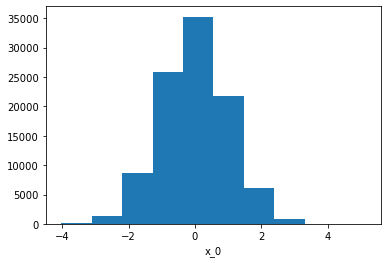

In [31]:
plt.hist(x);
plt.xlabel("x_0");

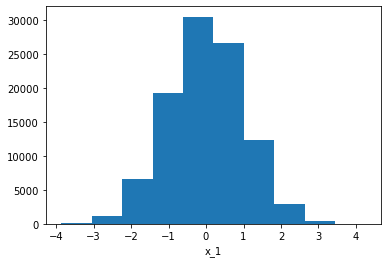

In [32]:
plt.hist(x2);
plt.xlabel("x_1");

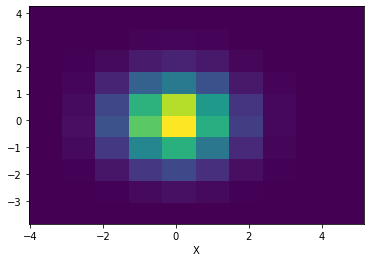

In [33]:
plt.hist2d(x, x2);
plt.xlabel("X");

In [34]:
Y = encoder_2d.predict(X)

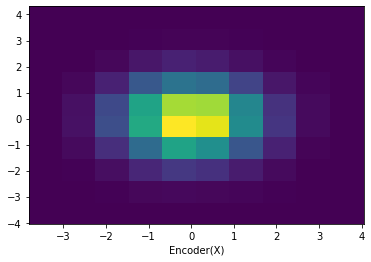

In [35]:
plt.hist2d(Y[:,0], Y[:,1]);
plt.xlabel("Encoder(X)");

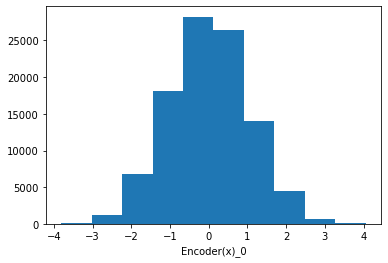

In [36]:
plt.hist(Y[:,0]);
plt.xlabel("Encoder(x)_0");

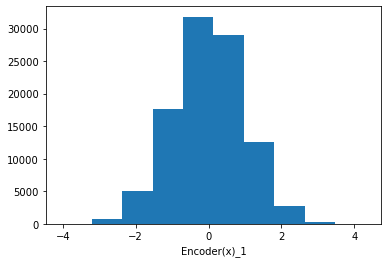

In [37]:
plt.hist(Y[:,1]);
plt.xlabel("Encoder(x)_1");

In [38]:
encoder_2d.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 15        
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
Total params: 57
Trainable params: 57
Non-trainable params: 0
_________________________________________________________________


In [62]:
print(np.shape(X))
print(np.shape(preds[:-1]))
model = LinearRegression().fit(X, preds[-1]);


(100000, 2)
(20, 100000, 2)


In [63]:
print('slope:', model.coef_)
print('intercept:', model.intercept_)

slope: [[-0.04123571  1.02879878]
 [ 0.97067397  0.04105201]]
intercept: [ 0.0058686 -0.0049123]


In [ ]:
#print([preds[:1][0][:,1],preds[:1][0][:,0]])